# Loading the Required Libraries

In [1]:
#loading the required libraries
# import util
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score, roc_curve
# from operator import itemgetter

from scipy import sparse
from dataset_maker import get_dateaa
import numpy as np
import datetime
import util
import networkx as nx
import random
from collections import defaultdict

# Training and Testing the Model

The below train function takes around 15 hours to train

In [3]:

#setting up the parameters
# ALPHA = 0.1
# H = 0.02
# WMV_LOSS_WIDTH = 0.0005
# REGULARIZATION_CONSTANT = 0.01
# LEARNING_RATE = 30
# NUM_TRAIN_USERS = 400
# MAX_POSITIVE_EDGES_PER_USER = 10
# MAX_NEGATIVE_EDGES_PER_USER = 10
# INITIAL_WEIGHTS = {
#     "age": 4,
#     "age_0.5": 0,
#     "age_0.2": 0,
#     "stars": 0,
#     "liked": 0,
#     "bias": -1
# }





ALPHA = 0.3
H = 0.02
WMV_LOSS_WIDTH = 0.0005
REGULARIZATION_CONSTANT = 0.00001
LEARNING_RATE = 30
NUM_TRAIN_USERS = 400
MAX_POSITIVE_EDGES_PER_USER = 5
MAX_NEGATIVE_EDGES_PER_USER = 100
INITIAL_WEIGHTS = {
    "age": 2,
    "age_0.5": 0,
    "age_0.2": 0,
    "stars": 0,
    "liked": 0,
    "bias": -2
}


#sigmoid function
def f(x):
    return 1 / (1 + np.exp(-x))

#used to calculate loss  
#Wilcoxon-Mann-Whitney loss  
def h(x):
    return 1 / (1 + np.exp(x / WMV_LOSS_WIDTH))


#function  to get the features of the review
def get_features(reviews, is_train):
    end_date = datetime.date(2012, 1, 1) if is_train else datetime.date(2013, 1, 1)
    #normalizing the features
    return {
        "age": 50.0 / ((end_date - get_date(reviews[0])).days + 30),
        "age_0.5": 10.0 / (((end_date - get_date(reviews[0])).days + 30) ** 0.5),
        "age_0.2": 3.0 / (((end_date - get_date(reviews[0])).days + 30) ** 0.2),
        "stars": int(reviews[0]["stars"]) / 5.0,
        "liked": 1 if int(reviews[0]["stars"]) > 3 else 0,
        "bias": 1.0
    }

#getting the features of each review given by each user to a business
def get_phi(is_train):
    data_dir = 'train' if is_train else 'test'

    print "Loading"
    reviews = util.load_json('./data/' + data_dir + '/review.json')

    G = nx.read_edgelist('./data/' + data_dir + '/graph.txt', nodetype=int)
    n = G.number_of_nodes()

    phi = defaultdict(lambda: sparse.lil_matrix((n, n), dtype=float))
    for (u, v) in G.edges():
        if str(u) not in reviews:
            u, v = v, u
        features = get_features(reviews[str(u)][str(v)], is_train)
        for feature_name, value in features.iteritems():
            phi[feature_name][u, v] = value
            phi[feature_name][v, u] = value

    print "Converting"
    for k, m in phi.items():
        phi[k] = sparse.csr_matrix(m)

    return phi


def get_Q(phi, w):
    a = sparse.csr_matrix((phi[0].shape), dtype=float)
    for k in w:
        #the feature vector(u,v) is mutiplied with the edge weights (w is to be learnt)
        a = a + phi[k] * w[k]
    a.data = f(a.data)
    d_inv = sparse.diags([[1.0 / a.getrow(i).sum() for i in range(a.shape[0])]], [0])
    return d_inv.dot(a)


def get_ps(Q, old_ps, max_iter=50, convergence_criteria=1e-4, log=False, examples=None):
    ps = {}
    total_iterations = 0
    ll = util.LoopLogger(10, len(old_ps), True)
    for u in old_ps:
        if log:
            ll.step()
        ps[u], iterations = stationary_distribution(Q, u, old_ps[u], max_iter, convergence_criteria)
        if examples:
            for b in examples[str(u)]:
                examples[str(u)][b] = ps[u][0, int(b)]
            del ps[u]
        total_iterations += iterations
    print "  average_iterations {:.2f}".format(total_iterations / float(len(old_ps)))
    return ps


def stationary_distribution(Q, u, p_init, max_iter=50, convergence_criteria=1e-4):
    p = p_init
    for i in range(max_iter):
        new_p = np.dot(p, Q)
        new_p *= (1 - ALPHA)
        new_p[0, u] += ALPHA
        delta = 0 if convergence_criteria == 0 else np.sum(abs((new_p - p).data))
        p = new_p
        if delta < convergence_criteria:
            break
    return p, (i + 1)


#function to calculate loss
def get_loss(ps, Ds, Ls, w):
    loss = 0
    for i, u in enumerate(ps):
        u_loss = 0
        u_updates = 0
        for d in Ds[u]:
            for l in Ls[u]:
                u_loss += h(ps[u][0, d] - ps[u][0, l])
                u_updates += 1
        loss += u_loss / u_updates

    loss /= len(ps)
    loss += REGULARIZATION_CONSTANT * np.sqrt(sum(wk ** 2 for wk in w.values()))

    return loss


def run(phi, w, Ds, Ls, old_ps):
    print "  w =", w
    Q = get_Q(phi, w)
    ps = get_ps(Q, old_ps)
    loss = get_loss(ps, Ds, Ls, w)
    return loss, ps


#function to train the model
def train():
    #getting features of each review
    phi = get_phi(True)

    print "Loading examples"
    Ds, Ls = {}, {}
    #loading the data
    examples = util.load_json('./data/train/examples.json')
    us = list(examples.keys())
    random.seed(0)
    random.shuffle(us)
    #extracting sample to train
    for u in us:
        D, L = set(), set()
        #finding positive and negative edges
        for b in examples[u]:
            (D if examples[u][b] == 1 else L).add(int(b))
        if len(D) > MAX_POSITIVE_EDGES_PER_USER:
            D = random.sample(D, MAX_POSITIVE_EDGES_PER_USER)
        if len(L) > MAX_NEGATIVE_EDGES_PER_USER:
            L = random.sample(L, MAX_POSITIVE_EDGES_PER_USER)
#         if len(D) > 10 and len(L) > 10:
#             Ds[int(u)] = list(D);Ls[int(u)] = list(L)
#             if len(Ds) > NUM_TRAIN_USERS:
#                 break
        if len(D) > 1 and len(L) > 10:
            Ds[int(u)] = list(D)
            Ls[int(u)] = list(L)
            if len(Ds) > NUM_TRAIN_USERS:
                break

    print "Setting initial conditions"
    ps = {}
    for u in Ds:
        p = np.zeros(phi['bias'].shape[0])
        p[u] = 1.0
        ps[u] = sparse.csr_matrix(p)
    #training the model
    #print "Training..."
    #initializing weights
    w = INITIAL_WEIGHTS
    best_loss = 100000
    for i in range(30):
        print "ITERATION " + str(i + 1) + ": base"
        base_loss, ps = run(phi, w, Ds, Ls, ps)
        if base_loss < best_loss:
            best_loss = base_loss
            #writing the learnt weights into a file
            util.write_json(w, './data/supervised_random_walks_weights.json')

        partials = {}
        for k in w:
            print "ITERATION " + str(i + 1) + ": " + k
            new_w = w.copy()
            new_w[k] += H
            new_loss, _ = run(phi, new_w, Ds, Ls, ps)
            partials[k] = (new_loss - base_loss) / H

            print partials[k] * LEARNING_RATE

        for (k, dwk) in partials.iteritems():
            #updating weights
            w[k] -= LEARNING_RATE * dwk

#function to run test case
def test():
    phi = get_phi(False)
    examples = util.load_json('./data/test/examples.json')
    w = util.load_json('./data/supervised_random_walks_weights.json')

    print "Computing Q and initializing..."
    Q = get_Q(phi, w)
    ps = {}
    for u in examples:
        p = np.zeros(phi['bias'].shape[0])
        p[int(u)] = 1.0
        ps[int(u)] = sparse.csr_matrix(p)
    get_ps(Q, ps, max_iter=20, convergence_criteria=0, log=True, examples=examples)

    print "Writing..."
    util.write_json(examples, './data/test/supervised_random_walks.json')



# ALPHA = 0.3
# H = 0.02
# WMV_LOSS_WIDTH = 0.0005
# REGULARIZATION_CONSTANT = 0.00001
# LEARNING_RATE = 3
# NUM_TRAIN_USERS = 500
# MAX_POSITIVE_EDGES_PER_USER = 100
# MAX_NEGATIVE_EDGES_PER_USER = 100
# INITIAL_WEIGHTS = {
#     "age": 2,
#     "age_0.5": 0,
#     "age_0.2": 0,
#     "stars": 0,
#     "liked": 0,
#     "bias": -2
# }  
    
#training the model
train()
#testing the trained model
test()


Loading
Converting
Loading examples
Setting initial conditions
Training...
ITERATION 1: base
  w = {'liked': 0, 'age': 2, 'bias': -2, 'stars': 0, 'age_0.2': 0, 'age_0.5': 0}


/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in double_scalars
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:105: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


  average_iterations 28.00
ITERATION 1: liked
  w = {'liked': 0.02, 'bias': -2, 'stars': 0, 'age': 2, 'age_0.2': 0, 'age_0.5': 0}
  average_iterations 6.54
0.058629550748812154
ITERATION 1: age
  w = {'liked': 0, 'bias': -2, 'stars': 0, 'age': 2.02, 'age_0.2': 0, 'age_0.5': 0}
  average_iterations 6.14
0.26279189517341983
ITERATION 1: bias
  w = {'liked': 0, 'bias': -1.98, 'stars': 0, 'age': 2, 'age_0.2': 0, 'age_0.5': 0}
  average_iterations 6.04
0.30731283246188124
ITERATION 1: stars
  w = {'liked': 0, 'bias': -2, 'stars': 0.02, 'age': 2, 'age_0.2': 0, 'age_0.5': 0}
  average_iterations 6.40
0.2668574014713654
ITERATION 1: age_0.2
  w = {'liked': 0, 'bias': -2, 'stars': 0, 'age': 2, 'age_0.2': 0.02, 'age_0.5': 0}
  average_iterations 5.99
0.2798478581674535
ITERATION 1: age_0.5
  w = {'liked': 0, 'bias': -2, 'stars': 0, 'age': 2, 'age_0.2': 0, 'age_0.5': 0.02}
  average_iterations 6.12
0.25752060161235435
ITERATION 2: base
  w = {'liked': -0.058629550748812154, 'age': 1.7372081048265

ITERATION 6: liked
  w = {'liked': 0.25844367687345104, 'bias': -2.315746571763559, 'stars': -0.100287568504831, 'age': 1.8918210070886492, 'age_0.2': -0.1694303082007964, 'age_0.5': -0.0524190378611844}
  average_iterations 5.90
-0.052561411276075276
ITERATION 6: age
  w = {'liked': 0.23844367687345103, 'bias': -2.315746571763559, 'stars': -0.100287568504831, 'age': 1.9118210070886492, 'age_0.2': -0.1694303082007964, 'age_0.5': -0.0524190378611844}
  average_iterations 4.74
-0.03282078848565462
ITERATION 6: bias
  w = {'liked': 0.23844367687345103, 'bias': -2.295746571763559, 'stars': -0.100287568504831, 'age': 1.8918210070886492, 'age_0.2': -0.1694303082007964, 'age_0.5': -0.0524190378611844}
  average_iterations 3.76
0.005631750388868095
ITERATION 6: stars
  w = {'liked': 0.23844367687345103, 'bias': -2.315746571763559, 'stars': -0.080287568504831, 'age': 1.8918210070886492, 'age_0.2': -0.1694303082007964, 'age_0.5': -0.0524190378611844}
  average_iterations 5.05
-0.0291655007066959

  average_iterations 3.97
-0.01062052505115818
ITERATION 10: age_0.5
  w = {'liked': 0.41298246051774123, 'bias': -2.347576261228694, 'stars': -0.005581336294468997, 'age': 2.0106474754050234, 'age_0.2': -0.1044774589142039, 'age_0.5': 0.11663608861479323}
  average_iterations 4.50
-0.03019803673920407
ITERATION 11: base
  w = {'liked': 0.444363017190752, 'age': 2.035645451461841, 'bias': -2.360212999159504, 'stars': 0.010501077729957453, 'age_0.2': -0.09385693386304572, 'age_0.5': 0.1268341253539973}
  average_iterations 6.77
ITERATION 11: liked
  w = {'liked': 0.464363017190752, 'bias': -2.360212999159504, 'stars': 0.010501077729957453, 'age': 2.035645451461841, 'age_0.2': -0.09385693386304572, 'age_0.5': 0.1268341253539973}
  average_iterations 5.75
-0.0277841532985712
ITERATION 11: age
  w = {'liked': 0.444363017190752, 'bias': -2.360212999159504, 'stars': 0.010501077729957453, 'age': 2.055645451461841, 'age_0.2': -0.09385693386304572, 'age_0.5': 0.1268341253539973}
  average_itera

  average_iterations 4.54
0.017560013688217024
ITERATION 15: stars
  w = {'liked': 0.5396673671400343, 'bias': -2.4221574696875736, 'stars': 0.07596105599381396, 'age': 2.1244628424115763, 'age_0.2': -0.06673839074036736, 'age_0.5': 0.22985626260077496}
  average_iterations 5.00
-0.00803644739230669
ITERATION 15: age_0.2
  w = {'liked': 0.5396673671400343, 'bias': -2.4221574696875736, 'stars': 0.05596105599381396, 'age': 2.1244628424115763, 'age_0.2': -0.046738390740367355, 'age_0.5': 0.22985626260077496}
  average_iterations 4.14
-0.004308442229900011
ITERATION 15: age_0.5
  w = {'liked': 0.5396673671400343, 'bias': -2.4221574696875736, 'stars': 0.05596105599381396, 'age': 2.1244628424115763, 'age_0.2': -0.06673839074036736, 'age_0.5': 0.24985626260077495}
  average_iterations 4.34
-0.02203227559727239
ITERATION 16: base
  w = {'liked': 0.5583377092960862, 'age': 2.1442546709629617, 'bias': -2.439717483375791, 'stars': 0.06399750338612065, 'age_0.2': -0.06242994851046735, 'age_0.5': 0

  average_iterations 5.64
-0.01291092706637298
ITERATION 20: age
  w = {'liked': 0.6205493599943102, 'bias': -2.5127533103699573, 'stars': 0.08926686139293372, 'age': 2.2377069594379297, 'age_0.2': -0.051308799672133976, 'age_0.5': 0.33289698730087913}
  average_iterations 4.01
-0.017019954609759358
ITERATION 20: bias
  w = {'liked': 0.6205493599943102, 'bias': -2.4927533103699573, 'stars': 0.08926686139293372, 'age': 2.2177069594379297, 'age_0.2': -0.051308799672133976, 'age_0.5': 0.33289698730087913}
  average_iterations 4.67
0.018905381749922956
ITERATION 20: stars
  w = {'liked': 0.6205493599943102, 'bias': -2.5127533103699573, 'stars': 0.10926686139293372, 'age': 2.2177069594379297, 'age_0.2': -0.051308799672133976, 'age_0.5': 0.33289698730087913}
  average_iterations 4.98
-0.0048819205982764124
ITERATION 20: age_0.2
  w = {'liked': 0.6205493599943102, 'bias': -2.5127533103699573, 'stars': 0.08926686139293372, 'age': 2.2177069594379297, 'age_0.2': -0.03130879967213397, 'age_0.5': 

  average_iterations 4.30
-0.01648188126820993
ITERATION 25: base
  w = {'liked': 0.6775616278508478, 'age': 2.2995901343618703, 'bias': -2.607376658866344, 'stars': 0.10996017253681045, 'age_0.2': -0.04729147358892294, 'age_0.5': 0.4209425184166504}
  average_iterations 5.24
ITERATION 25: liked
  w = {'liked': 0.6975616278508479, 'bias': -2.607376658866344, 'stars': 0.10996017253681045, 'age': 2.2995901343618703, 'age_0.2': -0.04729147358892294, 'age_0.5': 0.4209425184166504}
  average_iterations 5.64
-0.009405825672992307
ITERATION 25: age
  w = {'liked': 0.6775616278508478, 'bias': -2.607376658866344, 'stars': 0.10996017253681045, 'age': 2.3195901343618703, 'age_0.2': -0.04729147358892294, 'age_0.5': 0.4209425184166504}
  average_iterations 3.92
-0.015364262428901876
ITERATION 25: bias
  w = {'liked': 0.6775616278508478, 'bias': -2.587376658866344, 'stars': 0.10996017253681045, 'age': 2.2995901343618703, 'age_0.2': -0.04729147358892294, 'age_0.5': 0.4209425184166504}
  average_itera

  average_iterations 4.99
-0.002293644527140426
ITERATION 29: age_0.2
  w = {'liked': 0.7119937042037172, 'bias': -2.682666359025281, 'stars': 0.1216361402724686, 'age': 2.359437961974905, 'age_0.2': -0.02803176136258802, 'age_0.5': 0.48453445818391616}
  average_iterations 4.51
0.0007247026878598462
ITERATION 29: age_0.5
  w = {'liked': 0.7119937042037172, 'bias': -2.682666359025281, 'stars': 0.1216361402724686, 'age': 2.359437961974905, 'age_0.2': -0.04803176136258802, 'age_0.5': 0.5045344581839162}
  average_iterations 4.30
-0.014914283233746772
ITERATION 30: base
  w = {'liked': 0.7192848866231227, 'age': 2.373566181205263, 'bias': -2.7014938339851846, 'stars': 0.12392978479960903, 'age_0.2': -0.04875646405044787, 'age_0.5': 0.49944874141766293}
  average_iterations 5.12
ITERATION 30: liked
  w = {'liked': 0.7392848866231228, 'bias': -2.7014938339851846, 'stars': 0.12392978479960903, 'age': 2.373566181205263, 'age_0.2': -0.04875646405044787, 'age_0.5': 0.49944874141766293}
  averag

1130/8919, 12.7%, elapsed: 918.0s, remaining: 6327.9s
1140/8919, 12.8%, elapsed: 926.0s, remaining: 6318.6s
1150/8919, 12.9%, elapsed: 934.5s, remaining: 6313.1s
1160/8919, 13.0%, elapsed: 942.3s, remaining: 6303.1s
1170/8919, 13.1%, elapsed: 950.4s, remaining: 6294.6s
1180/8919, 13.2%, elapsed: 958.3s, remaining: 6285.2s
1190/8919, 13.3%, elapsed: 966.4s, remaining: 6277.0s
1200/8919, 13.5%, elapsed: 974.4s, remaining: 6267.7s
1210/8919, 13.6%, elapsed: 982.2s, remaining: 6258.0s
1220/8919, 13.7%, elapsed: 990.1s, remaining: 6248.2s
1230/8919, 13.8%, elapsed: 998.2s, remaining: 6240.1s
1240/8919, 13.9%, elapsed: 1006.1s, remaining: 6230.3s
1250/8919, 14.0%, elapsed: 1014.2s, remaining: 6222.1s
1260/8919, 14.1%, elapsed: 1022.1s, remaining: 6212.9s
1270/8919, 14.2%, elapsed: 1030.2s, remaining: 6204.9s
1280/8919, 14.4%, elapsed: 1038.2s, remaining: 6196.1s
1290/8919, 14.5%, elapsed: 1046.4s, remaining: 6188.2s
1300/8919, 14.6%, elapsed: 1054.4s, remaining: 6179.6s
1310/8919, 14.7%, ela

2630/8919, 29.5%, elapsed: 2135.1s, remaining: 5105.5s
2640/8919, 29.6%, elapsed: 2143.3s, remaining: 5097.7s
2650/8919, 29.7%, elapsed: 2151.6s, remaining: 5090.1s
2660/8919, 29.8%, elapsed: 2159.7s, remaining: 5081.7s
2670/8919, 29.9%, elapsed: 2167.7s, remaining: 5073.4s
2680/8919, 30.0%, elapsed: 2175.5s, remaining: 5064.5s
2690/8919, 30.2%, elapsed: 2183.4s, remaining: 5056.0s
2700/8919, 30.3%, elapsed: 2191.2s, remaining: 5047.1s
2710/8919, 30.4%, elapsed: 2199.0s, remaining: 5038.3s
2720/8919, 30.5%, elapsed: 2206.9s, remaining: 5029.5s
2730/8919, 30.6%, elapsed: 2214.7s, remaining: 5020.9s
2740/8919, 30.7%, elapsed: 2222.7s, remaining: 5012.4s
2750/8919, 30.8%, elapsed: 2230.7s, remaining: 5004.1s
2760/8919, 30.9%, elapsed: 2238.6s, remaining: 4995.4s
2770/8919, 31.1%, elapsed: 2246.8s, remaining: 4987.6s
2780/8919, 31.2%, elapsed: 2254.6s, remaining: 4978.7s
2790/8919, 31.3%, elapsed: 2262.6s, remaining: 4970.4s
2800/8919, 31.4%, elapsed: 2270.5s, remaining: 4961.9s
2810/8919,

4120/8919, 46.2%, elapsed: 3352.4s, remaining: 3904.9s
4130/8919, 46.3%, elapsed: 3361.6s, remaining: 3898.0s
4140/8919, 46.4%, elapsed: 3370.9s, remaining: 3891.2s
4150/8919, 46.5%, elapsed: 3380.0s, remaining: 3884.1s
4160/8919, 46.6%, elapsed: 3388.3s, remaining: 3876.1s
4170/8919, 46.8%, elapsed: 3396.3s, remaining: 3867.8s
4180/8919, 46.9%, elapsed: 3404.2s, remaining: 3859.5s
4190/8919, 47.0%, elapsed: 3412.2s, remaining: 3851.1s
4200/8919, 47.1%, elapsed: 3420.3s, remaining: 3843.0s
4210/8919, 47.2%, elapsed: 3428.4s, remaining: 3834.8s
4220/8919, 47.3%, elapsed: 3436.5s, remaining: 3826.6s
4230/8919, 47.4%, elapsed: 3444.9s, remaining: 3818.7s
4240/8919, 47.5%, elapsed: 3452.9s, remaining: 3810.4s
4250/8919, 47.7%, elapsed: 3460.7s, remaining: 3801.9s
4260/8919, 47.8%, elapsed: 3468.7s, remaining: 3793.6s
4270/8919, 47.9%, elapsed: 3476.7s, remaining: 3785.2s
4280/8919, 48.0%, elapsed: 3484.7s, remaining: 3777.0s
4290/8919, 48.1%, elapsed: 3492.7s, remaining: 3768.7s
4300/8919,

5610/8919, 62.9%, elapsed: 4565.0s, remaining: 2692.6s
5620/8919, 63.0%, elapsed: 4573.0s, remaining: 2684.4s
5630/8919, 63.1%, elapsed: 4580.6s, remaining: 2676.0s
5640/8919, 63.2%, elapsed: 4588.6s, remaining: 2667.8s
5650/8919, 63.3%, elapsed: 4596.6s, remaining: 2659.5s
5660/8919, 63.5%, elapsed: 4604.5s, remaining: 2651.3s
5670/8919, 63.6%, elapsed: 4612.6s, remaining: 2643.1s
5680/8919, 63.7%, elapsed: 4620.3s, remaining: 2634.7s
5690/8919, 63.8%, elapsed: 4628.3s, remaining: 2626.5s
5700/8919, 63.9%, elapsed: 4636.3s, remaining: 2618.3s
5710/8919, 64.0%, elapsed: 4644.3s, remaining: 2610.1s
5720/8919, 64.1%, elapsed: 4652.3s, remaining: 2601.9s
5730/8919, 64.2%, elapsed: 4660.5s, remaining: 2593.8s
5740/8919, 64.4%, elapsed: 4668.4s, remaining: 2585.5s
5750/8919, 64.5%, elapsed: 4676.6s, remaining: 2577.4s
5760/8919, 64.6%, elapsed: 4684.4s, remaining: 2569.1s
5770/8919, 64.7%, elapsed: 4692.2s, remaining: 2560.8s
5780/8919, 64.8%, elapsed: 4700.3s, remaining: 2552.6s
5790/8919,

7100/8919, 79.6%, elapsed: 5769.2s, remaining: 1478.1s
7110/8919, 79.7%, elapsed: 5777.2s, remaining: 1469.9s
7120/8919, 79.8%, elapsed: 5785.0s, remaining: 1461.7s
7130/8919, 79.9%, elapsed: 5793.0s, remaining: 1453.5s
7140/8919, 80.1%, elapsed: 5801.0s, remaining: 1445.4s
7150/8919, 80.2%, elapsed: 5809.1s, remaining: 1437.3s
7160/8919, 80.3%, elapsed: 5817.2s, remaining: 1429.1s
7170/8919, 80.4%, elapsed: 5825.4s, remaining: 1421.0s
7180/8919, 80.5%, elapsed: 5833.6s, remaining: 1412.9s
7190/8919, 80.6%, elapsed: 5841.6s, remaining: 1404.7s
7200/8919, 80.7%, elapsed: 5849.8s, remaining: 1396.6s
7210/8919, 80.8%, elapsed: 5858.0s, remaining: 1388.5s
7220/8919, 81.0%, elapsed: 5865.8s, remaining: 1380.3s
7230/8919, 81.1%, elapsed: 5873.8s, remaining: 1372.2s
7240/8919, 81.2%, elapsed: 5881.7s, remaining: 1364.0s
7250/8919, 81.3%, elapsed: 5889.4s, remaining: 1355.8s
7260/8919, 81.4%, elapsed: 5897.4s, remaining: 1347.6s
7270/8919, 81.5%, elapsed: 5905.4s, remaining: 1339.5s
7280/8919,

8610/8919, 96.5%, elapsed: 7004.4s, remaining: 251.4s
8620/8919, 96.6%, elapsed: 7012.1s, remaining: 243.2s
8630/8919, 96.8%, elapsed: 7019.9s, remaining: 235.1s
8640/8919, 96.9%, elapsed: 7027.9s, remaining: 226.9s
8650/8919, 97.0%, elapsed: 7035.9s, remaining: 218.8s
8660/8919, 97.1%, elapsed: 7044.0s, remaining: 210.7s
8670/8919, 97.2%, elapsed: 7051.9s, remaining: 202.5s
8680/8919, 97.3%, elapsed: 7060.1s, remaining: 194.4s
8690/8919, 97.4%, elapsed: 7068.0s, remaining: 186.3s
8700/8919, 97.5%, elapsed: 7075.9s, remaining: 178.1s
8710/8919, 97.7%, elapsed: 7083.8s, remaining: 170.0s
8720/8919, 97.8%, elapsed: 7091.5s, remaining: 161.8s
8730/8919, 97.9%, elapsed: 7099.6s, remaining: 153.7s
8740/8919, 98.0%, elapsed: 7107.4s, remaining: 145.6s
8750/8919, 98.1%, elapsed: 7115.5s, remaining: 137.4s
8760/8919, 98.2%, elapsed: 7123.5s, remaining: 129.3s
8770/8919, 98.3%, elapsed: 7131.3s, remaining: 121.2s
8780/8919, 98.4%, elapsed: 7139.0s, remaining: 113.0s
8790/8919, 98.6%, elapsed: 7

# Evaluating the model

Method: supervised_random_walks
  Precision @20 = 0.0352
  ROC Auc = 0.8301


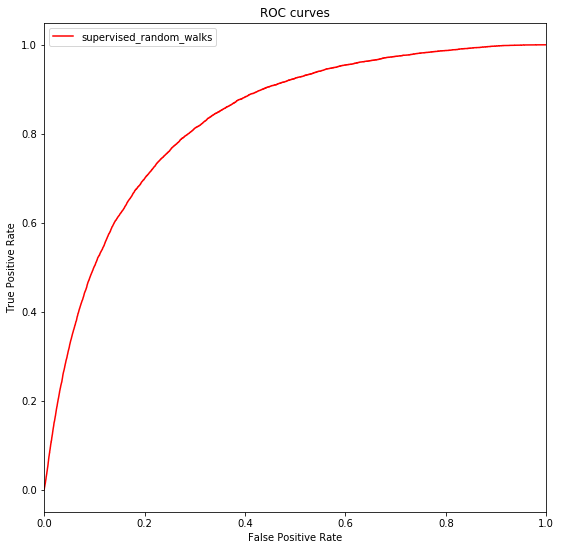

In [2]:
import util
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from operator import itemgetter


# COLORS = ['b', 'r', 'g', 'm', 'y', 'c', 'k', '#FF9900', '#F06600', '#663300']
COLORS = ['r', 'b', 'g', 'm', 'y', 'c', 'k', '#FF9900', '#006600', '#663300']


def run_evaluation(examples, precision_at=20):
    curve_args = []
    
    #The percent of the top 20 highest scoring predicted edges going from a given user that will exist at time t'
    #getting the prediction data 
    predictions = util.load_json('./data/test/supervised_random_walks.json')
    total_precision = 0
    all_ys, all_ps = [], []
    for u in predictions:
        ys, ps = zip(*[(examples[u][b], predictions[u][b]) for b in predictions[u]])
        all_ys += ys
        all_ps += ps

        n = min(precision_at, len(ys))
        top_ys = zip(*sorted(zip(ys, ps), key=itemgetter(1), reverse=True))[0][:n]
        total_precision += sum(top_ys) / float(n)
    #calculating ROC
    roc_auc = roc_auc_score(all_ys, all_ps)
    fpr, tpr, t = roc_curve(all_ys, all_ps)
    curve_args.append((fpr, tpr, method, COLORS[i % len(COLORS)]))
    #printing the summary
    print "Method:",' supervised_random_walks'
    print "  Precision = {:.4f}".format(total_precision / len(examples))
    print "  ROC Auc = {:.4f}".format(roc_auc)

#     if i >= len(COLORS):
#         print "Too many methods to plot all of them!"
#         return
    #ploting hte ROC 
    plt.figure(figsize=(9, 9))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.title('ROC curves')
    for (fpr, tpr, label, color) in curve_args:
        plt.plot(fpr, tpr, label=label, color=color)
    plt.legend(loc="best")
    plt.show()

#run_evaluation(util.load_json('data/test/examples.json'),30)
#ploting the data that was tested/



run_evaluation(util.load_json('data/test/examples.json'))